# 图像分类

这个教程展示了如何对❀进行分类,使用`keras.Sequential`创建图像分类模型,使用`preprocessing.image_dataset_from_directory`加载数据.你将获得以下学习内容:

- 从磁盘高效加载数据

- 识别过拟合并使用技术来减轻过度拟合，包括数据增加和丢弃神经元。

本教程遵循基本的机器学习工作流:

1. 理解和检查数据
2. 编译输入管道
3. 构建模型
4. 训练模型
5. 测试模型
6. 模型优化和复现

## 导入必要的库

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 下载并解压数据

本教程使用的数据集包括3700张❀的图片,数据集包含五个子文件夹,他们每一类是:
```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [35]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

下载完成之后,你可以将数据集拷贝到其他地方,总共有3670张图片

In [36]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


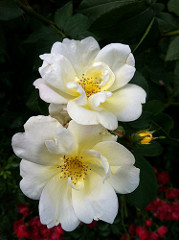

In [37]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

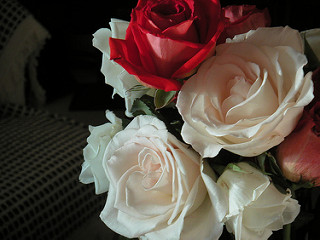

In [38]:
PIL.Image.open(str(roses[1]))

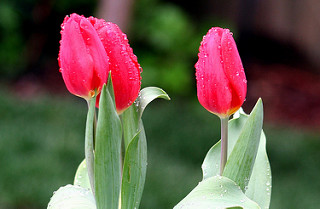

In [39]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

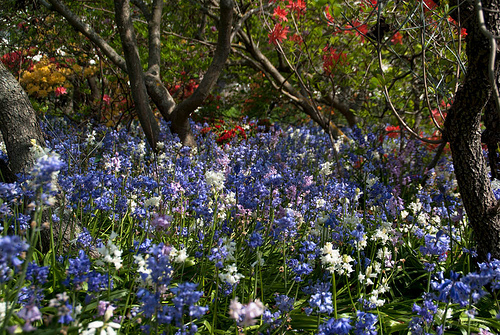

In [40]:
PIL.Image.open(str(tulips[1]))

## 使用keras.preprocessing加载数据

让我们使用`keras.preprocessing`从磁盘中加载数据.只需要几行代码即可从磁盘上的映像目录转到tf.data.Dataset。如果愿意，还可以通过访问LoadImages教程从头开始编写自己的数据加载代码。

### 创建数据集

给加载器定义一些参数

In [41]:
batch_size = 32
img_height = 180
img_width = 180

在开发你的模型的时候使用验证分割是很好的实践.让我们使用80%的数据训练,20%的数据验证

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


你可以使用`class_name`属性找到这些类的名字.它们与按字母顺序排列的目录名相对应

In [44]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## 数据可视化

下面是训练集中的九个图像

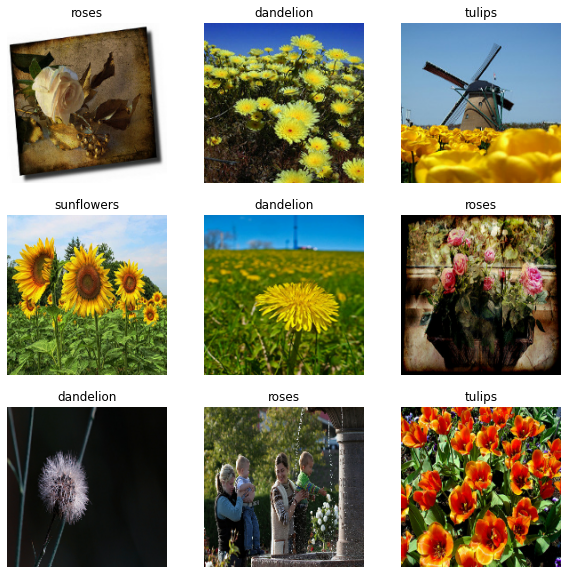

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

你会使用`model.fit`去训练模型,如果你喜欢,你可以手动迭代数据并生成批数据的检索

In [46]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`是一个维度为`(32, 180, 180, 3)`的张量,它是由32张维度为`180x180x3`(最后一维为RGB通道).`laebl_batch`是维度为`(32,)`的张量,它们与32张图片相对应.你可以调用`.numpy()`将`image_batch`和`laebl_batch`转换为`numpy.ndarray`

## 提高数据加载性能

让我们确保使用缓冲预取，这样您就可以在不阻塞I/O的情况下从磁盘生成数据。在加载数据时，您应该使用这两种重要方法。

`Dataset.cache()`在第一个epoch期间将图像从磁盘上加载后保存在内存中。这将确保数据集不会成为模型训练的瓶颈。如果数据集太大而无法放入内存中，则也可以使用此方法创建高性能的磁盘缓存。
`Dataset.prefetch()`在训练过程中，数据预处理和模型执行重叠。

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 标准化数据

RGB通道数据数值在`[0, 255]`区间内,对于神经网络来说这是不理想的.通常你应当让你的输入尽可能地小,你可以使用Rescaling layer将数据标准化为`[0, 1]`区间内.

有两种方式使用该层,你可以通过calling map去应用到数据集上

In [48]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0008662854 0.9806694


或者你可以将该层包含到你的模型定义里,这样可以简化部署,我们这里使用第二种方式

> 之前在使用`image_dataset_from_directory`函数时,里面的`image_size`参数可以对图像重新调整尺寸,如果你想将重新划分尺寸的逻辑包含在模型中,你可以使用Rescaling layer

## 创建模型

该模型由三个卷积块组成，每个卷积块中都有一个最大池层。有一个128单元全连接的层,由relu激活函数激活。此模型尚未针对高精度进行调整，本教程的目标是展示标准方法。

In [49]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## 编译模型

在本教程中,优化器使用`optimizers.Adam`损失函数使用`losses.SparseCategoricalCrossentropy`.通过`metrics`参数可以看到每个循环的训练和验证的准确率

In [50]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## 打印模型

使用模型的`summary`方法查看网络所有层

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

## 训练模型

In [52]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 2s 23ms/step - loss: 1.3405 - accuracy: 0.4111 - val_loss: 1.0914 - val_accuracy: 0.5572
Epoch 2/10
92/92 [==============================] - 1s 13ms/step - loss: 1.0402 - accuracy: 0.5845 - val_loss: 1.0490 - val_accuracy: 0.5627
Epoch 3/10
92/92 [==============================] - 1s 13ms/step - loss: 0.8742 - accuracy: 0.6706 - val_loss: 0.9401 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 1s 12ms/step - loss: 0.6754 - accuracy: 0.7425 - val_loss: 0.9036 - val_accuracy: 0.6226
Epoch 5/10
92/92 [==============================] - 1s 12ms/step - loss: 0.4669 - accuracy: 0.8311 - val_loss: 1.0594 - val_accuracy: 0.6117
Epoch 6/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2584 - accuracy: 0.9138 - val_loss: 1.1716 - val_accuracy: 0.6485
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.1563 - accuracy: 0.9554 - val_loss: 1.3670 - val_accuracy: 0.6335
Epoch 8/10
92

## 结果可视化

创建训练集和验证集的准确率和损失曲线

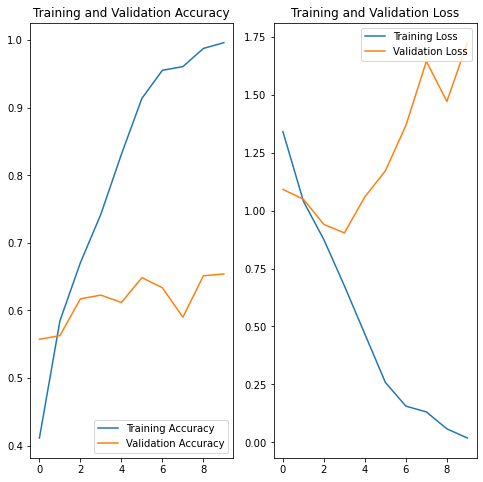

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

从图中可以看出,训练准确度和验证准确度相差很大,模型在验证集上的准确度只有60%左右.
让我们看看哪里出了问题,并尝试提高模型的整体性能.

## 过拟合

在上面的图中,随着时间的推移,训练精度呈线性增加,而验证准确度在训练过程中会停滞在60%左右.此外,培训和验证准确性之间的准确性差异是显而易见的,这是过度拟合的迹象.
当新的训练样本对模型的性能产生负面影响时,有时会有一些不必要的例子从模型中学习到.这种现象被称为过度拟合.这意味着模型很难在新的数据集上泛化.
在训练过程中有多种方法可以对抗过度适应.在本教程中,您将使用数据扩充并将Dropout添加到模型中.

## 数据增强

过拟合通过发生在训练样本较少的情况下.数据增强是指通过使用随机转换（产生可信的图像）来从现有示例中生成额外的训练数据的方法.这有助于模型接触到多种类型的数据,并更好地进行泛化。

In [54]:
data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

让我们来可视化一些通过对同一个图像多次应用数据增强的示例:

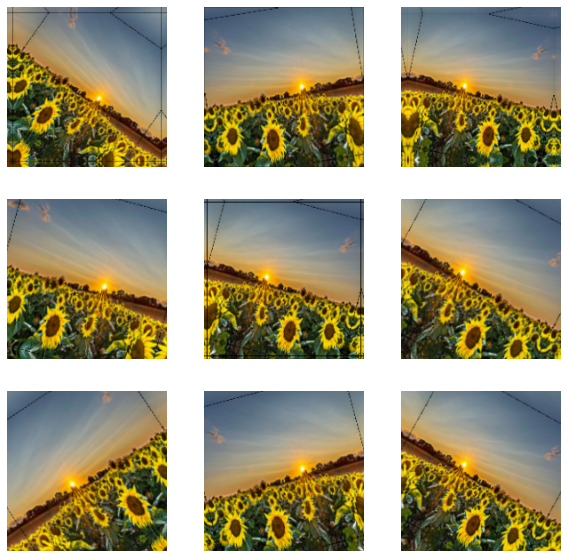

In [55]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

接下来将数据增强应用到模型训练中

## Dropout

另一种抑制过拟合的技术就是在网络中使用`Dropout`来进行正则化.

当你在网络中使用`Dropout`的时候,训练过程中它会在输出层中随即丢弃一些输出单元,Dropout以一个小数作为输入值，其形式为0.1、0.2、0.4等。这意味着从应用层随机丢弃10%、20%或40%的输出单元.
让我们创建一个使用`layers.Dropout`的神经网络,按然后使用数据增强去训练它

In [56]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## 编译训练模型

In [57]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [59]:
epochs = 15
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 [==============================] - 1s 15ms/step - loss: 1.3090 - accuracy: 0.4411 - val_loss: 1.1655 - val_accuracy: 0.5272
Epoch 2/15
92/92 [==============================] - 1s 14ms/step - loss: 1.0763 - accuracy: 0.5688 - val_loss: 0.9950 - val_accuracy: 0.6022
Epoch 3/15
92/92 [==============================] - 1s 14ms/step - loss: 0.9621 - accuracy: 0.6247 - val_loss: 0.9939 - val_accuracy: 0.5954
Epoch 4/15
92/92 [==============================] - 1s 14ms/step - loss: 0.9204 - accuracy: 0.6403 - val_loss: 0.8795 - val_accuracy: 0.6512
Epoch 5/15
92/92 [==============================] - 1s 14ms/step - loss: 0.8507 - accuracy: 0.6730 - val_loss: 0.8883 - val_accuracy: 0.6390
Epoch 6/15
92/92 [==============================] - 1s 14ms/step - loss: 0.8100 - accuracy: 0.6860 - val_loss: 0.7957 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 1s 14ms/step - loss: 0.7622 - accuracy: 0.7040 - val_loss: 0.7923 - val_accuracy: 0.6894
Epoch 8/15
92

## 结果展示

在使用数据增强和随机丢弃之后,过拟合现象较之前相比减轻,训练和验证准确率接近

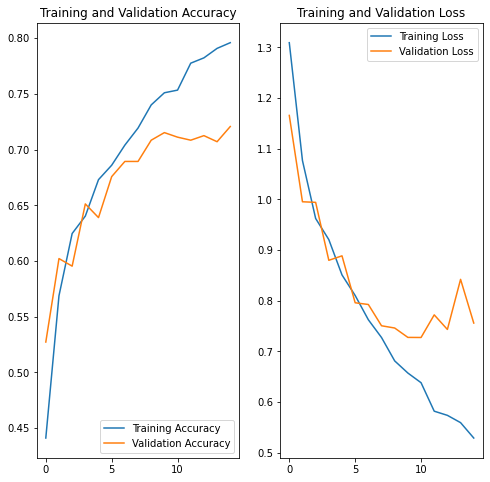

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 在新数据上进行预测

最后,让我们使用模型对新数据进行推理

In [62]:
from tensorflow import keras

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 97.16 percent confidence.
